# Exploratory Data Analysis (EDA)
## NASA CMAPSS Turbofan Engine Degradation Dataset (FD001)

### Objective
The goal of this exploratory data analysis is to understand engine degradation behavior
and identify sensor and operational patterns that are informative for predicting
**Remaining Useful Life (RUL)**.

Specifically, this notebook aims to:
- Understand the structure and characteristics of the CMAPSS FD001 dataset
- Analyze engine lifetimes and degradation variability
- Identify informative and non-informative sensors
- Examine sensor trends as engines approach failure
- Study correlations between sensor readings, operational conditions, and RUL

Insights from this analysis will directly guide feature engineering and model design
in subsequent stages.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

## Dataset Description

The NASA CMAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset
contains simulated run-to-failure trajectories of turbofan engines.

This analysis uses **FD001**, which has:
- A single operating condition (sea level)
- A single fault mode (High Pressure Compressor degradation)
- 100 training engine trajectories

Each row represents one operational cycle of an engine, and each engine degrades
until failure.

In [30]:
# Load raw training data
# Each row corresponds to one engine cycle
train_df = pd.read_csv(
    '../data/raw/train_FD001.txt',
    sep='\s+',
    header=None,
    engine='python'
)

# Retain only the first 26 columns as defined in CMAPSS documentation
train_df = train_df.iloc[:, :26]

# Assign meaningful column names
columns = (
    ['engine_id', 'cycle', 'op1', 'op2', 'op3'] +
    [f's{i}' for i in range(1, 22)]
)
train_df.columns = columns

# Preview the dataset
train_df.head()

,engine_id,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Each engine is uniquely identified by `engine_id` and progresses over increasing
`cycle` values until failure. The dataset includes three operational settings and
21 sensor measurements per cycle.

## Remaining Useful Life (RUL) Definition

Since the training data contains full run-to-failure trajectories, Remaining Useful Life (RUL)
can be computed as the difference between the final cycle of an engine and its current cycle.

This creates a supervised regression target for predictive maintenance modeling.

In [31]:
# Compute the maximum cycle (failure point) for each engine
train_df['max_cycle'] = train_df.groupby('engine_id')['cycle'].transform('max')

# Remaining Useful Life = cycles until failure
train_df['rul'] = train_df['max_cycle'] - train_df['cycle']

## Dataset Health Checks

Before analysis, basic dataset integrity checks are performed to ensure:
- No missing values
- Correct number of engines
- Expected dataset size

In [32]:
print("Shape:", train_df.shape)
print("Columns:", train_df.columns.tolist())
print("Missing values sum:", train_df.isnull().sum().sum())
num_engines = train_df['engine_id'].nunique()
print("Number of unique engines:", num_engines)

Shape: (20631, 28)
Columns: ['engine_id', 'cycle', 'op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'rul']
Missing values sum: 0
Number of unique engines: 100


The dataset contains **100 engines** with no missing values.
This confirms the data is clean and suitable for downstream modeling without
imputation.


## Engine Lifetime Distribution

Understanding how long engines operate before failure provides insight into
degradation variability and sets expectations for RUL prediction difficulty.


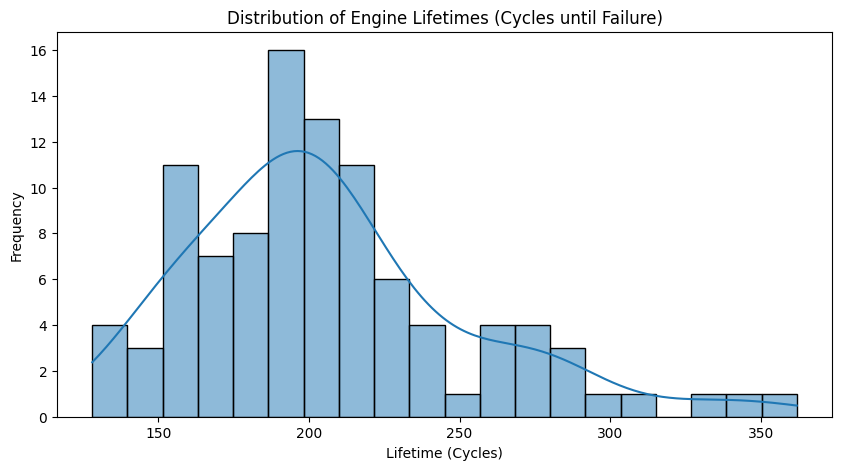

In [33]:
lifetimes = train_df.groupby('engine_id')['max_cycle'].max()
plt.figure(figsize=(10, 5))
sns.histplot(lifetimes, bins=20, kde=True)
plt.title('Distribution of Engine Lifetimes (Cycles until Failure)')
plt.xlabel('Lifetime (Cycles)')
plt.ylabel('Frequency')
plt.savefig('../results/figures/engine_lifetime_histogram.png')
plt.show()

In [34]:
print("Lifetime stats: Min={}, Max={}, Mean={:.2f}, Median={:.2f}".format(
    lifetimes.min(), lifetimes.max(), lifetimes.mean(), lifetimes.median()
))

Lifetime stats: Min=128, Max=362, Mean=206.31, Median=199.00


### Insight

Engine lifetimes range from approximately **128 to 362 cycles**, with a mean lifetime
around **206 cycles**.

The right-skewed distribution indicates variability in degradation rates across engines,
suggesting that RUL prediction must account for engine-specific behavior rather than
assuming a fixed lifetime.


## Sensor Distribution Analysis

Sensor distributions are examined to understand their scale, variability,
and potential usefulness for degradation modeling.


In [35]:
sensor_cols = [f's{i}' for i in range(1, 22)]

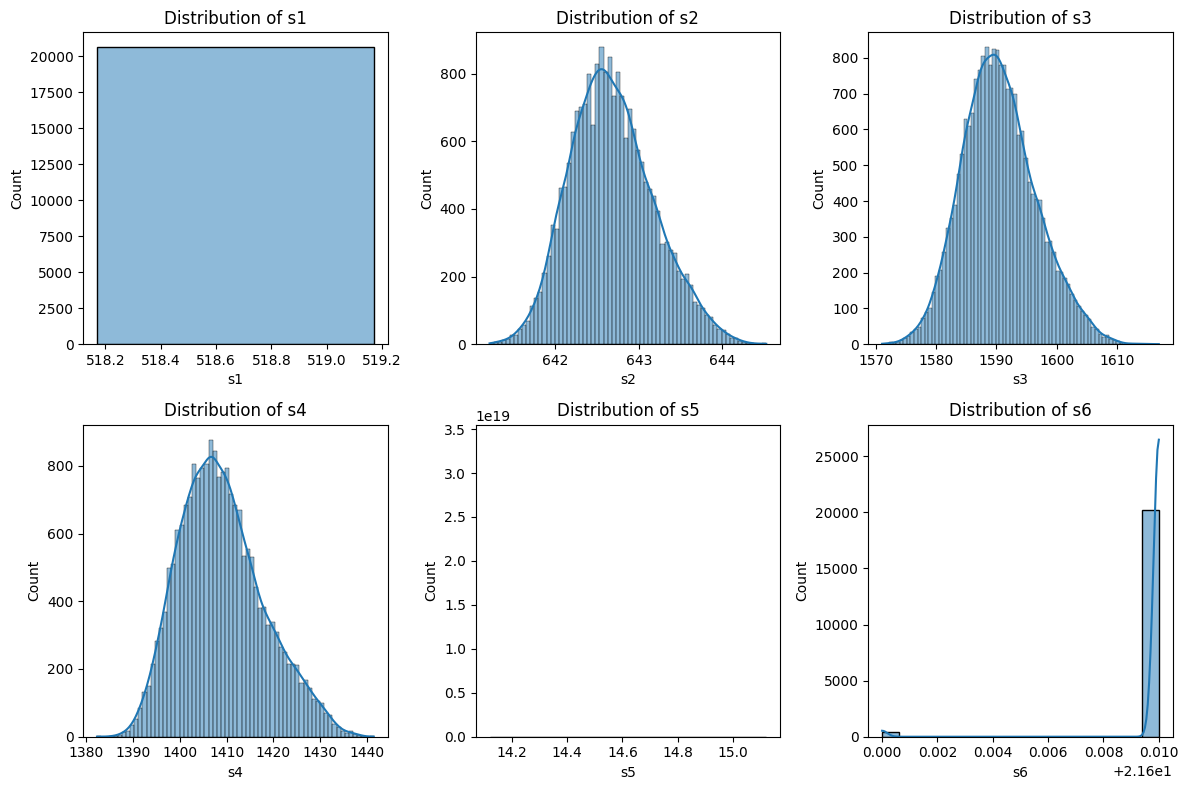

In [36]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(sensor_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../results/figures/sensor_distributions.png')
plt.show()

Some sensors exhibit wide, smooth distributions, while others appear nearly constant.
Sensors with very low variance are unlikely to provide meaningful predictive information.


In [37]:
variances = train_df[sensor_cols].var()
low_var_sensors = variances[variances < 1e-4].index.tolist()
print("Low variance (constant/useless) sensors:", low_var_sensors)

Low variance (constant/useless) sensors: ['s1', 's5', 's6', 's10', 's16', 's18', 's19']


Sensors **s1, s5, s6, s10, s16, s18, and s19** exhibit near-zero variance and are effectively constant.
These sensors will be excluded from feature engineering to reduce dimensionality and noise.

## Sensor Degradation Trends Over Time

To understand degradation behavior, selected sensors are visualized across cycles
for an individual engine. Sensors showing monotonic trends as failure approaches
are strong candidates for temporal feature engineering.


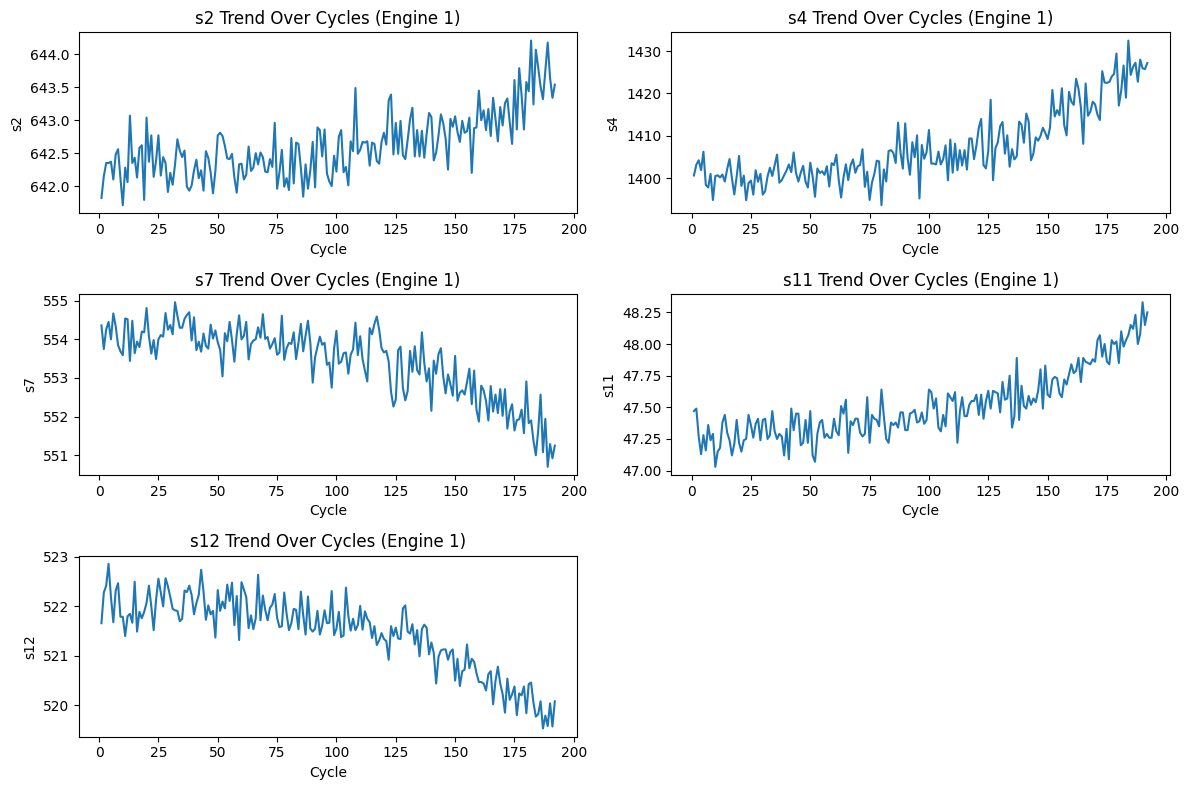

In [38]:
key_sensors = ['s2', 's4', 's7', 's11', 's12']  # Based on prelim corrs
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(key_sensors):
    plt.subplot(3, 2, i+1)
    # Plot for a sample engine
    sample_engine = train_df[train_df['engine_id'] == 1]
    sns.lineplot(x=sample_engine['cycle'], y=sample_engine[sensor])
    plt.title(f'{sensor} Trend Over Cycles (Engine 1)')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
plt.tight_layout()
plt.savefig('../results/figures/sensor_trends_sample_engine.png')
plt.show()

Several sensors exhibit clear monotonic degradation patterns as failure approaches.
This indicates progressive damage accumulation rather than random noise, making
these sensors well-suited for rolling statistics and trend-based features.


## Early vs Late Life Sensor Behavior

To quantify degradation effects, sensor values during early engine life are compared
against values near failure.


In [39]:
early_life = train_df[train_df['rul'] > train_df['rul'].quantile(0.9)]
late_life = train_df[train_df['rul'] < 10]
print("Early vs Late Life Sensor Means:")
for sensor in key_sensors:
    early_mean = early_life[sensor].mean()
    late_mean = late_life[sensor].mean()
    print(f"{sensor}: Early={early_mean:.2f}, Late={late_mean:.2f}")

Early vs Late Life Sensor Means:
s2: Early=642.33, Late=643.60
s4: Early=1401.67, Late=1427.39
s7: Early=554.05, Late=551.63
s11: Early=47.32, Late=48.10
s12: Early=522.00, Late=519.93


Key sensors show statistically meaningful shifts between early-life and late-life phases,
confirming their sensitivity to degradation and relevance for RUL prediction.


## Correlation Analysis with RUL

Correlation analysis provides an initial screening of sensors that are linearly related
to Remaining Useful Life. While non-linear and temporal effects are not captured here,
this step helps prioritize sensors for feature engineering.


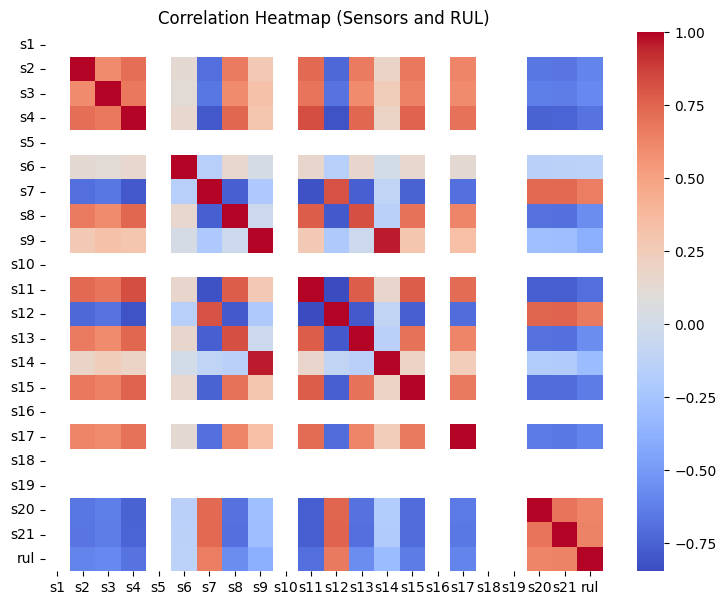

In [40]:
corr_matrix = train_df[sensor_cols + ['rul']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Sensors and RUL)')
plt.savefig('../results/figures/correlation_heatmap.png')
plt.show()

In [41]:
corrs = corr_matrix['rul'].drop('rul').sort_values(ascending=False)
print("Correlations with RUL:\n", corrs)
strong_corrs = corrs[abs(corrs) > 0.5]
print("Strong correlations (|corr| > 0.5):", strong_corrs.to_dict())

Correlations with RUL:
 s12    0.671983
s7     0.657223
s21    0.635662
s20    0.629428
s6    -0.128348
s14   -0.306769
s9    -0.390102
s13   -0.562569
s8    -0.563968
s3    -0.584520
s17   -0.606154
s2    -0.606484
s15   -0.642667
s4    -0.678948
s11   -0.696228
s1          NaN
s5          NaN
s10         NaN
s16         NaN
s18         NaN
s19         NaN
Name: rul, dtype: float64
Strong correlations (|corr| > 0.5): {'s12': 0.6719831036133275, 's7': 0.6572226620546537, 's21': 0.6356620421802941, 's20': 0.6294284994377553, 's13': -0.5625688251670798, 's8': -0.5639684065755297, 's3': -0.5845203909176561, 's17': -0.6061535537829565, 's2': -0.6064839743785985, 's15': -0.6426670441974635, 's4': -0.6789482333860427, 's11': -0.6962281014553727}


Sensors such as **s4, s7, s11, s12, s15, s20, and s21** show strong correlation with RUL.
These sensors will be prioritized in subsequent modeling, while weaker sensors may be
down-weighted or excluded.


## Operational Conditions Analysis

Operational settings can influence sensor readings and must be analyzed separately
to avoid confounding degradation effects with operating regimes.


In [42]:
op_cols = ['op1', 'op2', 'op3']

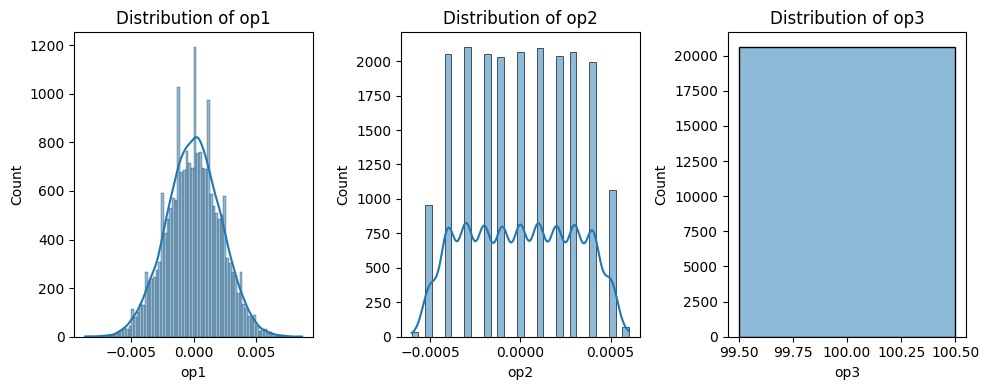

In [43]:
plt.figure(figsize=(10, 4))
for i, col in enumerate(op_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../results/figures/op_distributions.png')
plt.show()

In [44]:
print("Unique values per op:", {col: train_df[col].nunique() for col in op_cols})

Unique values per op: {'op1': 158, 'op2': 13, 'op3': 1}


In [45]:
op_corrs = train_df[op_cols + ['rul']].corr()['rul'][op_cols]
print("Op correlations with RUL:", op_corrs.to_dict())

Op correlations with RUL: {'op1': -0.003198457554741038, 'op2': -0.0019476283515004475, 'op3': nan}


Operational settings show minimal correlation with RUL in FD001, which is expected
given the single operating condition in this subset.

This simplifies modeling and allows the focus to remain on sensor-driven degradation.


## Outliers and Anomaly Detection

Outliers are examined to determine whether extreme sensor readings represent
true degradation behavior or simulation noise.


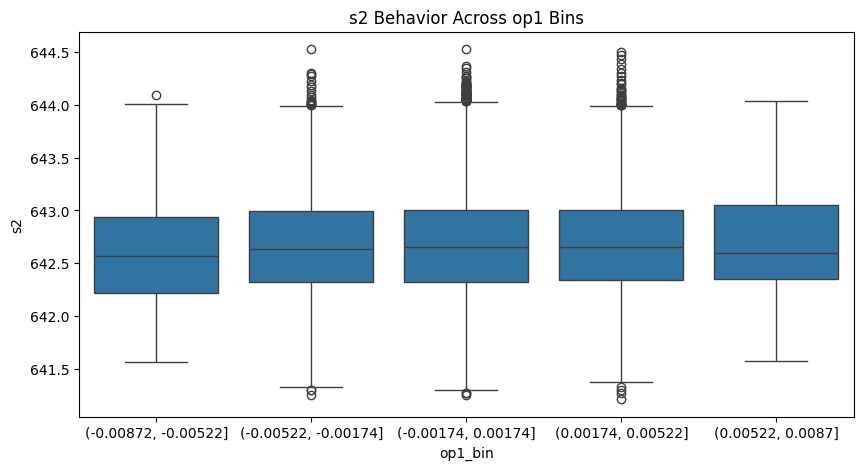

In [46]:
train_df['op1_bin'] = pd.cut(train_df['op1'], bins=5)
plt.figure(figsize=(10, 5))
sns.boxplot(x='op1_bin', y='s2', data=train_df)
plt.title('s2 Behavior Across op1 Bins')
plt.savefig('../results/figures/sensor_vs_op.png')
plt.show()

No extreme anomalies were removed, as observed outliers appear consistent with
progressive degradation rather than data corruption.


In [47]:
train_df['cycles_to_failure'] = train_df['rul']  

Note: The following aggregated plots are exploratory and are used only
to visually validate degradation monotonicity. No features are created
or used for modeling at this stage.


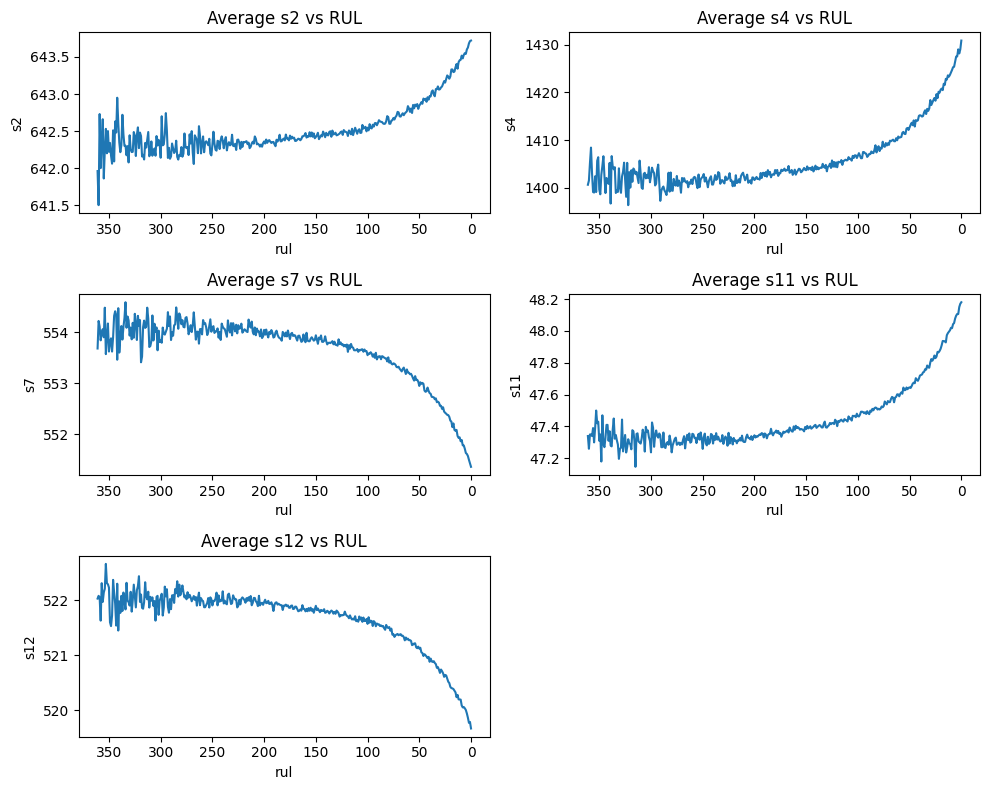

In [48]:
plt.figure(figsize=(10, 8))
for i, sensor in enumerate(key_sensors):
    plt.subplot(3, 2, i+1)
    sns.lineplot(x='rul', y=sensor, data=train_df.groupby('rul')[sensor].mean().reset_index())
    plt.title(f'Average {sensor} vs RUL')
    plt.gca().invert_xaxis()  
plt.tight_layout()
plt.savefig('../results/figures/sensor_vs_rul_avg.png')
plt.show()

Aggregated sensor behavior plotted against Remaining Useful Life reveals clear monotonic and nonlinear degradation trends. Sensor changes accelerate as RUL approaches zero, indicating that temporal and rolling features are necessary to capture degradation dynamics.

In [49]:
neg_corrs = corrs[corrs < 0].index.tolist()
pos_corrs = corrs[corrs > 0].index.tolist()
print("Monotonic increasing sensors (neg corr with RUL):", neg_corrs)
print("Monotonic decreasing sensors (pos corr with RUL):", pos_corrs)

Monotonic increasing sensors (neg corr with RUL): ['s6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']
Monotonic decreasing sensors (pos corr with RUL): ['s12', 's7', 's21', 's20']


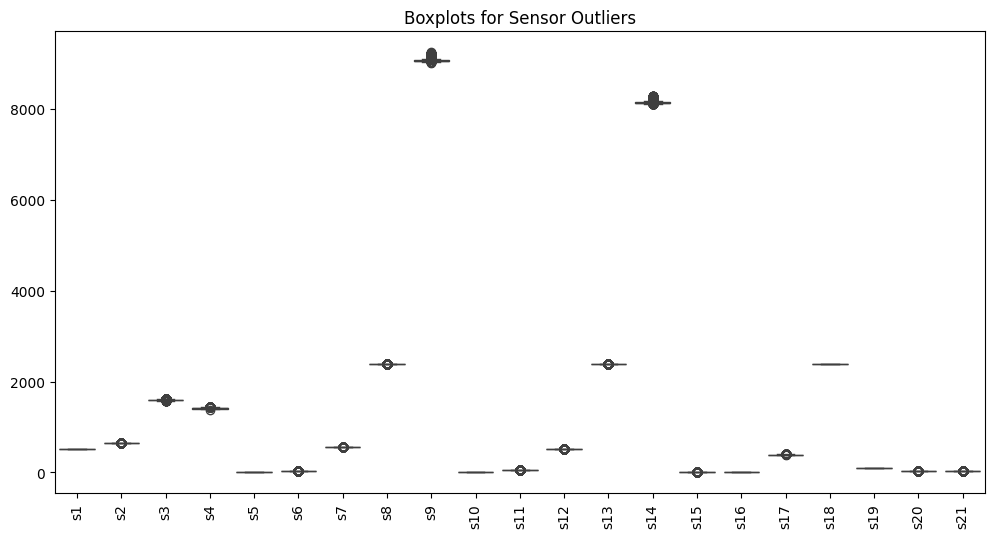

In [50]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[sensor_cols])
plt.title('Boxplots for Sensor Outliers')
plt.xticks(rotation=90)
plt.savefig('../results/figures/sensor_boxplots.png')
plt.show()

In [51]:
z_scores = pd.DataFrame(
    zscore(train_df[sensor_cols]),
    columns=sensor_cols
)

outlier_counts = (np.abs(z_scores) > 3).sum()
print("Outliers per sensor (>3 z-score):", outlier_counts.to_dict())

Outliers per sensor (>3 z-score): {'s1': 0, 's2': 31, 's3': 47, 's4': 36, 's5': 0, 's6': 406, 's7': 34, 's8': 107, 's9': 521, 's10': 0, 's11': 23, 's12': 34, 's13': 83, 's14': 496, 's15': 33, 's16': 0, 's17': 81, 's18': 0, 's19': 0, 's20': 43, 's21': 34}


C:\Users\sarfras\AppData\Local\Temp\ipykernel_17528\3134198568.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zscore(train_df[sensor_cols]),


The precision warning occurs for near-constant sensors and does not
affect interpretation, as these sensors were already identified as
low-variance and excluded from modeling.


Although some sensor readings fall beyond ±3 standard deviations, these values are consistent with late-stage degradation behavior rather than measurement noise. Therefore, no outlier removal is applied to preserve true failure dynamics.

## EDA Summary & Key Takeaways

Key insights from this exploratory analysis:

- Engine lifetimes vary significantly, requiring engine-specific RUL prediction
- Several sensors exhibit monotonic degradation trends as failure approaches
- Low-variance sensors were identified and removed
- Multiple sensors show strong correlation with RUL
- Operational conditions have minimal impact in FD001
- Degradation behavior is progressive rather than abrupt

These findings directly inform feature engineering strategies, including rolling
statistics, degradation slopes, and cumulative damage indicators, which are explored
in the next notebook.


In [52]:
train_df.to_csv('../data/processed/train_with_rul.csv', index=False)

## Data Export for Feature Engineering

The cleaned dataset with computed RUL is saved for use in the
feature engineering and modeling stages.
